In [1]:
# exploring options to optimise particle filter params
# by optimising for accuracy over realworld log

# log was taken using nav-stack to drive around the office, and intermittently logging ground truth poses manually
# throughout the run

In [2]:
from typing import List
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from cbl_particle_filter.filter import load_input_log
from cbl_particle_filter.carpet_map import load_map_from_png
from cbl_particle_filter.filter import Pose, CarpetBasedParticleFilter, offline_playback
from cbl_particle_filter.visualisation import plot_map

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [3]:
log_dir = Path("../logs/20210708_office_patrol_five_loops/").resolve()
log_file = f"{log_dir}/localiser_input_log.pickle"
map_png = f"{log_dir}/office_map.png"

In [4]:
carpet = load_map_from_png(map_png, cell_size=0.5)

In [5]:
log = load_input_log(log_file)
# log has two incorrect waypoint - remove them
del log[3824]
del log[3825]

# for i, m in enumerate(log):
#     o, c, p = m
#     if p is not None:
#         print(f"{i=} {p=}")
start_pose = log[1][2]
print(start_pose)

Pose(x=5.034027099609375, y=5.528431415557861, heading=1.5710755586624146)


In [6]:
def perform_playback(
    log,
    carpet_map,
    seed_pose,
    pf_params=dict(),
    ):
    """
    Localise over given log, returning a dataframe of localised poses and
    ground truth
    """
    
    np.random.seed(123)
    
    localised_poses = offline_playback(
        input_data = log,
        carpet = carpet,
        seed_pose = seed_pose,
        use_seed_messages=False,
        **pf_params,
    )    
    
    # convert results to dataframe
    ground_truth_poses = [gt_pose for _, _, gt_pose in log]

    df_data = []
    for ground_truth_pose, localised_pose in zip(ground_truth_poses, localised_poses):
        if ground_truth_pose:
            gt_x = ground_truth_pose.x
            gt_y = ground_truth_pose.y
        else:
            gt_x = float("nan")
            gt_y = float("nan")
            
        df_data.append({
            "gt_x":gt_x,
            "gt_y":gt_y,
            "loc_x":localised_pose.x,
            "loc_y":localised_pose.y,
        })
    return pd.DataFrame(df_data)

def plot_results(results_df:pd.DataFrame):    
    fig, ax = plt.subplots()
    plot_map(carpet, show=False)
    plt.plot(results_df.loc_x, results_df.loc_y, color='tab:green', marker='o',markersize=3)
    plt.plot(results_df.gt_x, results_df.gt_y, color='tab:orange', marker='o', linewidth=2)
    
    lines = [((row.loc_x, row.loc_y), (row.gt_x, row.gt_y)) for _, row in results_df.iterrows()]
    lc = mc.LineCollection(lines, colors="red")
    ax.add_collection(lc)

    plt.axis('off')
    plt.legend(['ground truth', 'particle filter output'])
    plt.show()
    
def get_playback_error(
    log,
    carpet_map,
    seed_pose,
    plot=False,
    print_inidividual_errors=False,
    pf_params=dict()
    ):
    """
    Report sum squared position error for playback of the given log
    """
    results_df = perform_playback(
        log,
        carpet_map,
        seed_pose,
        pf_params=pf_params,
    )
    ground_truth_results = results_df[~np.isnan(results_df.gt_x)].copy()
    ground_truth_results.loc[:,"position_error"] = np.linalg.norm(
        np.vstack(
            [
                ground_truth_results.loc_x - ground_truth_results.gt_x,
                ground_truth_results.loc_y - ground_truth_results.gt_y
            ]
        ),axis=0
    )
    if print_inidividual_errors:
        print(ground_truth_results)
        
    sum_squared_error = sum(np.power(ground_truth_results["position_error"],2))
    
    if plot:
        plot_results(results_df)

    return sum_squared_error

In [7]:
# The next few cells explore different values for odom_pos_noise
# Results indicate lower values are better

          gt_x      gt_y     loc_x     loc_y  position_error
1     5.034027  5.528431  5.218542  5.672466        0.234076
886   4.950554  5.575613  5.004683  5.561231        0.056007
1938  4.887591  5.594236  5.091446  5.557043        0.207221
2626  5.061856  5.469752  5.365462  5.435680        0.305511
3233  4.955660  5.536246  5.038775  5.637519        0.131012
3885  4.971214  5.453076  4.990623  5.591337        0.139616


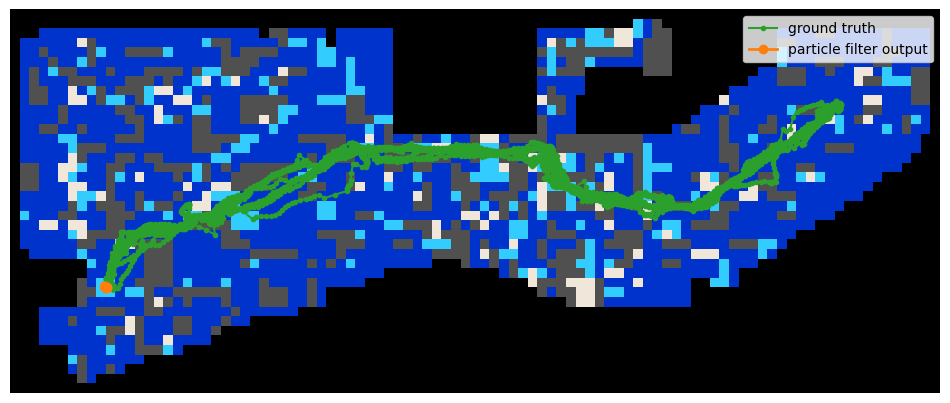

0.23086276224034666

In [8]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    plot=True,
    print_inidividual_errors=True,
    pf_params=dict(
        resample_proportion=0,
        weight_fn_p=0.9,
        odom_pos_noise=0.05,
        odom_heading_noise=0.05,
        n_particles=500,
    ),
)

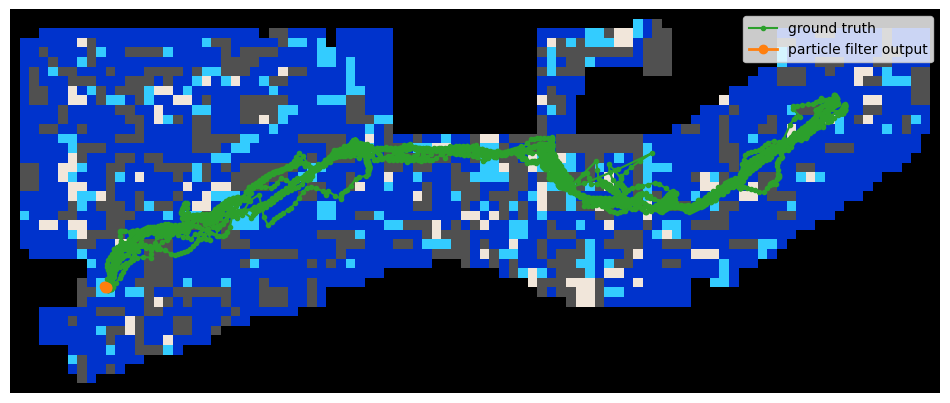

0.09207016139307668

In [9]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    plot=True,
    pf_params=dict(
        resample_proportion=0,
        weight_fn_p=0.9,
        odom_pos_noise=0.1,
        odom_heading_noise=0.05,
        n_particles=500,
    )
)

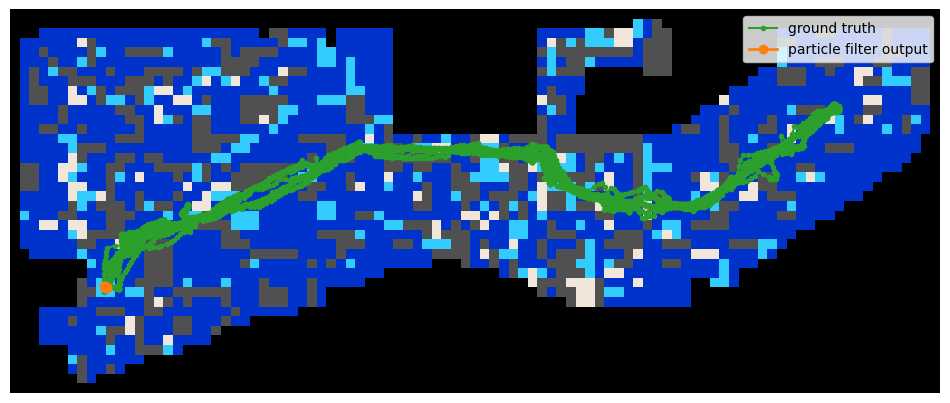

0.5862645770681024

In [10]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    plot=True,
    pf_params=dict(
        resample_proportion=0,
        weight_fn_p=0.9,
        odom_pos_noise=0.01,
        odom_heading_noise=0.05,
        n_particles=500,
    ),
)

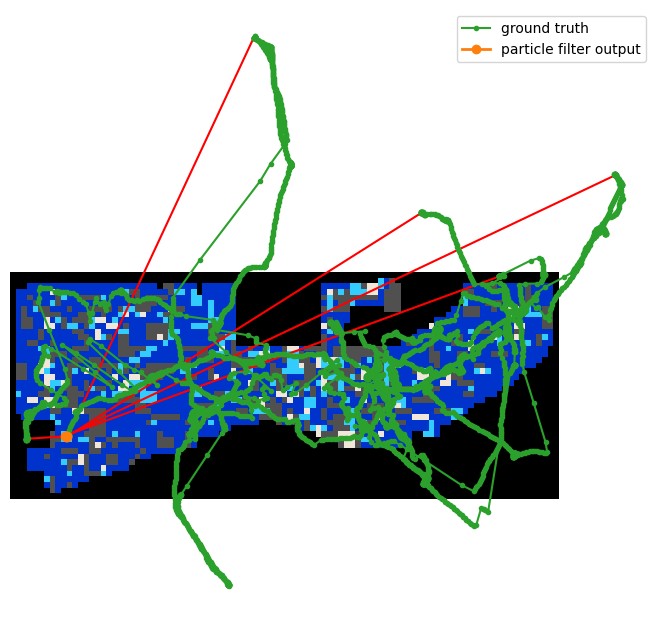

7488.052486955499

In [11]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    plot=True,
    pf_params=dict(
        resample_proportion=0,
        weight_fn_p=0.9,
        odom_pos_noise=0.0,
        odom_heading_noise=0.05,
        n_particles=500,
    )
)

In [12]:
# Try some parameter value sweeps to look for minima in a more automated fashion

In [13]:
def test_parameter_range(parameter_name:str, parameter_values:List, default_params:dict=dict()):
    print("default params:")
    param_print(default_params)
    print()
    for parameter_value in parameter_values:
        pf_params = default_params.copy()
        pf_params.update({parameter_name:parameter_value})
        error = get_playback_error(
            log,
            carpet,
            seed_pose=start_pose,
            plot=False,
            pf_params=pf_params,        
        )
        print(f"{parameter_name}={parameter_value},\t{error=}")
                         
default_params = dict(
    resample_proportion=0,
    weight_fn_p=0.9,
    odom_pos_noise=0.0,
    odom_heading_noise=0.05,
    n_particles=500,
)

def param_print(params:dict):
    for k,v in params.items():
        print(f"  {k}={v}")

In [14]:
test_parameter_range("odom_pos_noise",[0, 0.005, 0.01, 0.02, 0.1, 1.0], default_params)

default params:
  resample_proportion=0
  weight_fn_p=0.9
  odom_pos_noise=0.0
  odom_heading_noise=0.05
  n_particles=500

odom_pos_noise=0,	error=7488.052486955499
odom_pos_noise=0.005,	error=0.39898220306533594
odom_pos_noise=0.01,	error=0.5862645770681024
odom_pos_noise=0.02,	error=0.3808035230699099
odom_pos_noise=0.1,	error=0.09207016139307668
odom_pos_noise=1.0,	error=380.75818159681853


In [15]:
# the best value was achieved at odom_pos_noise=0, although, I'd be a bit more comfortable
# using 0.01 or 0.02, as this more closely matches reality (there is some noise)

# Conclusion - further test odom_pos_noise=0
default_params['odom_pos_noise'] = 0.0

In [16]:
test_parameter_range("odom_heading_noise",[0, 0.005, 0.01, 0.05, 0.1, 1.0], default_params)

default params:
  resample_proportion=0
  weight_fn_p=0.9
  odom_pos_noise=0.0
  odom_heading_noise=0.05
  n_particles=500

odom_heading_noise=0,	error=160.6837126767799
odom_heading_noise=0.005,	error=21.41934950238844
odom_heading_noise=0.01,	error=179.00911630713486
odom_heading_noise=0.05,	error=7488.052486955499
odom_heading_noise=0.1,	error=424.7791377390457
odom_heading_noise=1.0,	error=301.60976915366393


In [17]:
# odom_heading_noise looks good around 0.05, with much larger errors either side
# -> do some more focussed tests

In [18]:
test_parameter_range("odom_heading_noise",np.linspace(0.0, 0.1, 9), default_params)

default params:
  resample_proportion=0
  weight_fn_p=0.9
  odom_pos_noise=0.0
  odom_heading_noise=0.05
  n_particles=500

odom_heading_noise=0.0,	error=160.6837126767799
odom_heading_noise=0.0125,	error=311.48260526416175
odom_heading_noise=0.025,	error=143.64042699762004
odom_heading_noise=0.037500000000000006,	error=0.2585226574337304
odom_heading_noise=0.05,	error=7488.052486955499
odom_heading_noise=0.0625,	error=1777.0262282529511
odom_heading_noise=0.07500000000000001,	error=0.5023389265570675
odom_heading_noise=0.08750000000000001,	error=18.46689025793957
odom_heading_noise=0.1,	error=424.7791377390457


In [19]:
# Conclusion - some local minima, but best result at 0.025
default_params['odom_heading_noise'] = 0.025

In [20]:
test_parameter_range("resample_proportion",[0, 0.01, 0.1, 1.0], default_params)

default params:
  resample_proportion=0
  weight_fn_p=0.9
  odom_pos_noise=0.0
  odom_heading_noise=0.025
  n_particles=500

resample_proportion=0,	error=143.64042699762004
resample_proportion=0.01,	error=2229.6629568254198
resample_proportion=0.1,	error=1366.384439075466
resample_proportion=1.0,	error=1479.0155422604673


In [21]:
# resample proportion doesn't appear to help at all.
# My assumption would be that this resampling increases the chance of recovering from loss of localisation,
# at the expense of degrading accuracy in the normal case.

# Conclusion - keep using resample_proportion=0

In [22]:
test_parameter_range("weight_fn_p",[0.5, 0.8, 0.9, 0.95, 0.99, 1.0], default_params)

default params:
  resample_proportion=0
  weight_fn_p=0.9
  odom_pos_noise=0.0
  odom_heading_noise=0.025
  n_particles=500

weight_fn_p=0.5,	error=686.1209657080666
weight_fn_p=0.8,	error=0.14665409115933434
weight_fn_p=0.9,	error=143.64042699762004
weight_fn_p=0.95,	error=8153.090818543491
weight_fn_p=0.99,	error=2248.498256845428


/home/tfanselo/projects/personal/20210106_cbl/carpet_localisation/venv/lib/python3.8/site-packages/pfilter/pfilter.py:347: RuntimeWarning: divide by zero encountered in log
  self.weight_entropy = np.sum(self.weights * np.log(self.weights))
/home/tfanselo/projects/personal/20210106_cbl/carpet_localisation/venv/lib/python3.8/site-packages/pfilter/pfilter.py:347: RuntimeWarning: invalid value encountered in multiply
  self.weight_entropy = np.sum(self.weights * np.log(self.weights))
/home/tfanselo/projects/personal/20210106_cbl/carpet_localisation/venv/lib/python3.8/site-packages/pfilter/pfilter.py:342: RuntimeWarning: invalid value encountered in true_divide
  self.weights = weights / self.weight_normalisation


weight_fn_p=1.0,	error=nan


In [23]:
# Conclusion - use weight_fn_p=0.9
default_params['weight_fn_p'] = 0.9

In [24]:
test_parameter_range("n_particles",[10, 100, 1000, 10000], default_params)

default params:
  resample_proportion=0
  weight_fn_p=0.9
  odom_pos_noise=0.0
  odom_heading_noise=0.025
  n_particles=500

n_particles=10,	error=817.1812019646368
n_particles=100,	error=2112.3503905596126
n_particles=1000,	error=3486.4850029567374
n_particles=10000,	error=0.16534991427308654


In [25]:
# More particles = better, but 10k is pretty slow to run. 


In [26]:
# more focused particle number testing
test_parameter_range("n_particles",[100, 200, 300, 500, 700, 1000], default_params)

default params:
  resample_proportion=0
  weight_fn_p=0.9
  odom_pos_noise=0.0
  odom_heading_noise=0.025
  n_particles=500

n_particles=100,	error=2112.3503905596126
n_particles=200,	error=642.2365897995994
n_particles=300,	error=73.225430442147
n_particles=500,	error=143.64042699762004
n_particles=700,	error=0.27013112123487054
n_particles=1000,	error=3486.4850029567374


In [27]:
# anything over 100 does not appear to have a large effect on error, although I'd still want to keep the number
# high for general robustness (don't want to overfit this limited dataset)

# Received best results with n=500, so will stick with that

# Conclusion - use n_particles=500
default_params['n_particles'] = 500

Best guess params:
  resample_proportion=0
  weight_fn_p=0.9
  odom_pos_noise=0.0
  odom_heading_noise=0.025
  n_particles=500


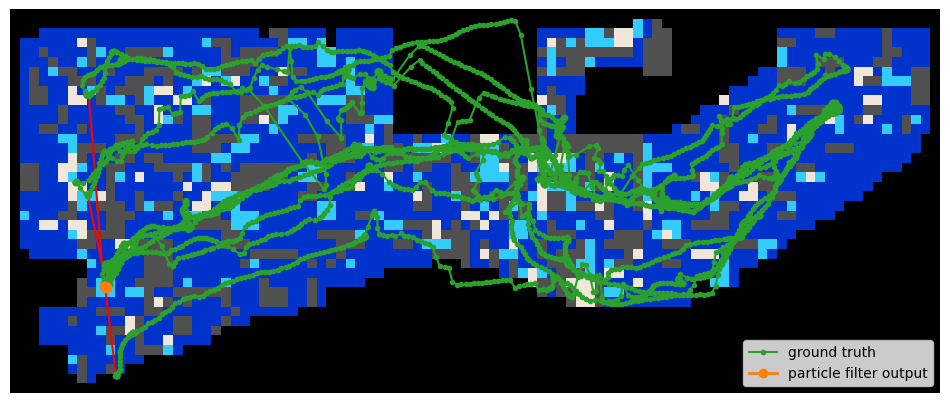

143.64042699762004

In [28]:
# current best guess
print("Best guess params:")
param_print(default_params)
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    plot=True,
    pf_params=default_params
)

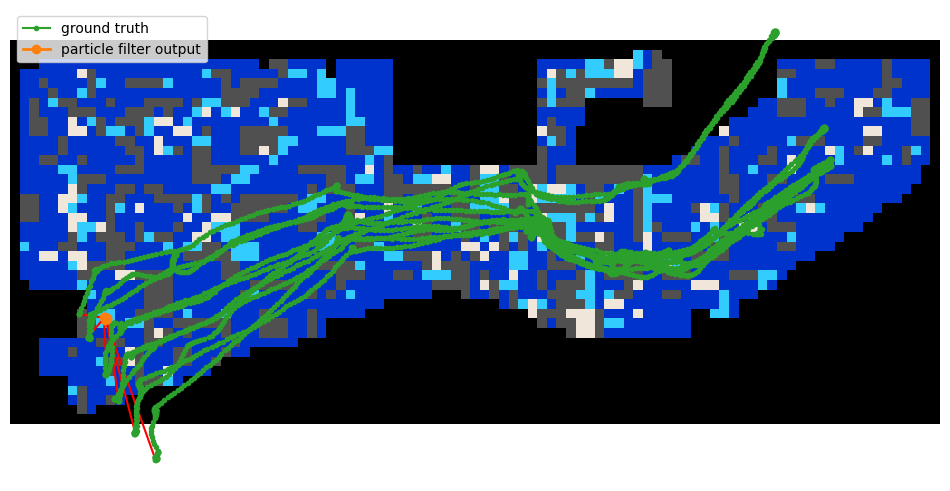

127.25386843798958

In [29]:
# Try odom only

# use slightly different heading, to make dead reckoning line up with actual trajectory 
# a little better
odom_seed = Pose(x=start_pose.x, y=start_pose.y, heading=start_pose.heading + np.pi/180*5)

get_playback_error(
        log,
        carpet,
        seed_pose=odom_seed,
        plot=True,
        pf_params=dict(
            odom_pos_noise=0.0,
            odom_heading_noise=0.0,
            resample_proportion=0,
            weight_fn_p = 0.5,
            n_particles = 2
        )
    )

In [30]:
# not awful, but a fair amount of angular drift over time. Also some amount of scale error